<h1 style="color:orange">EXERCISE CLASS 4</h1>

# Theory Recap

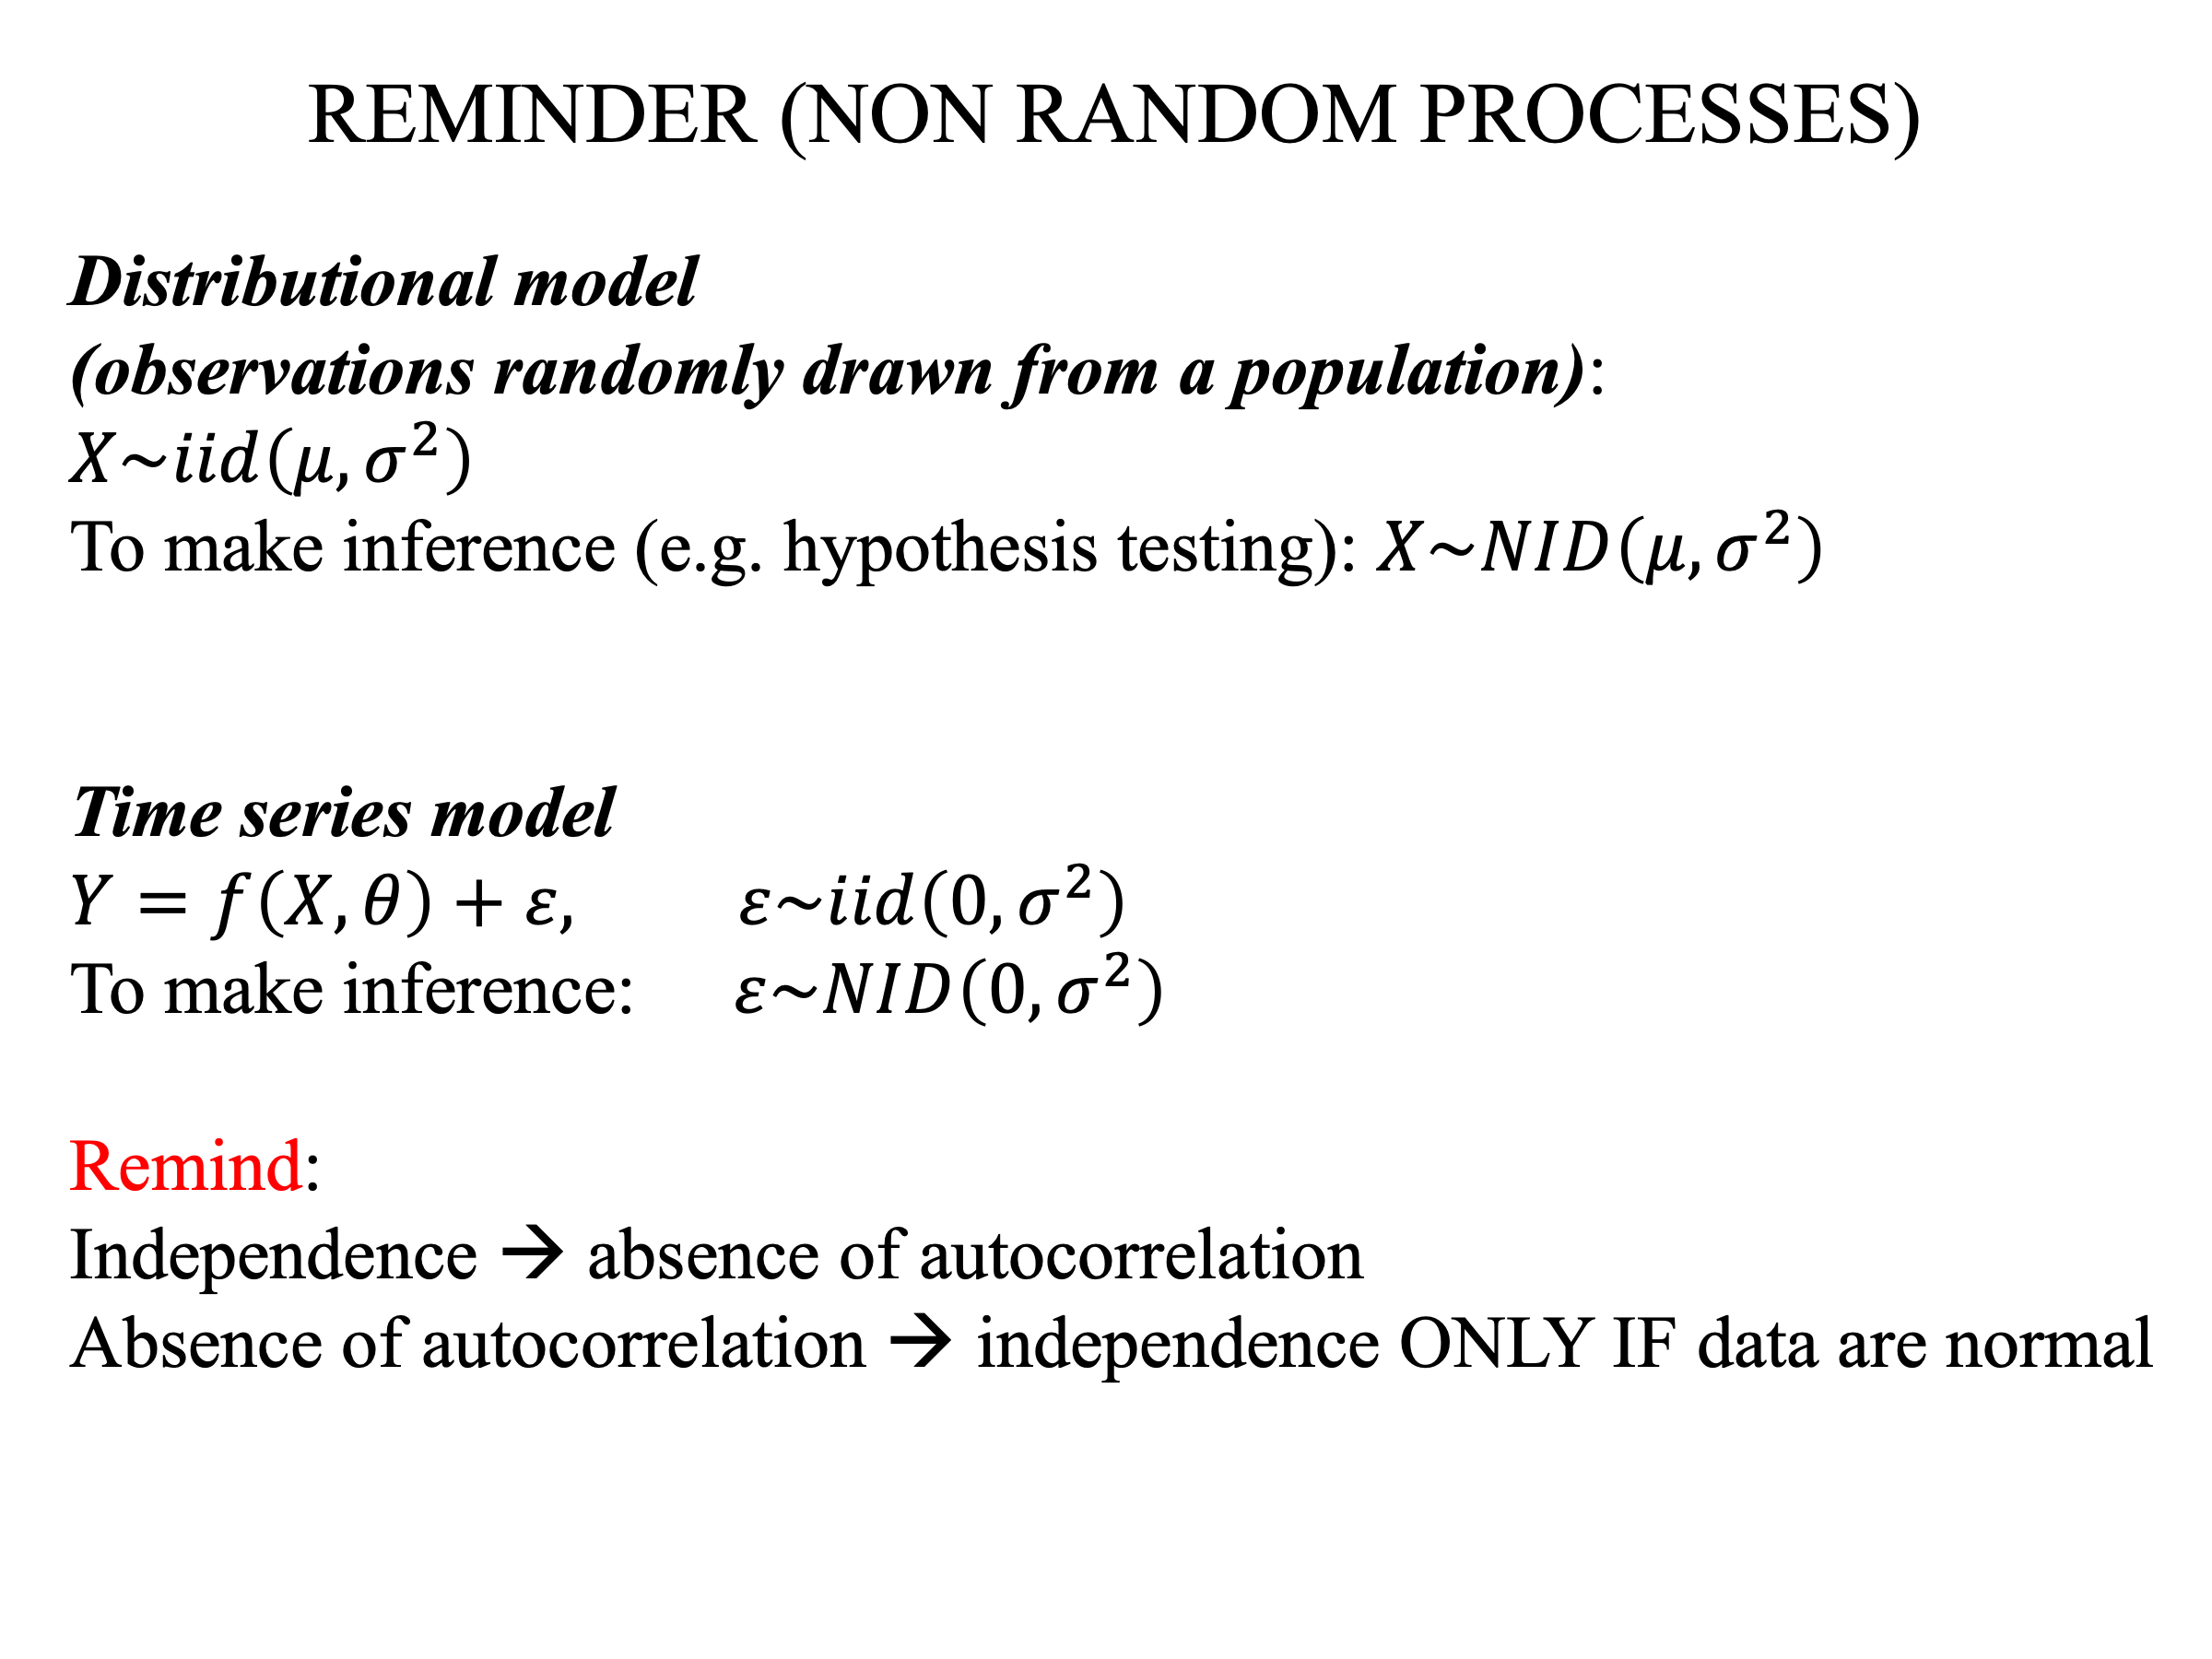
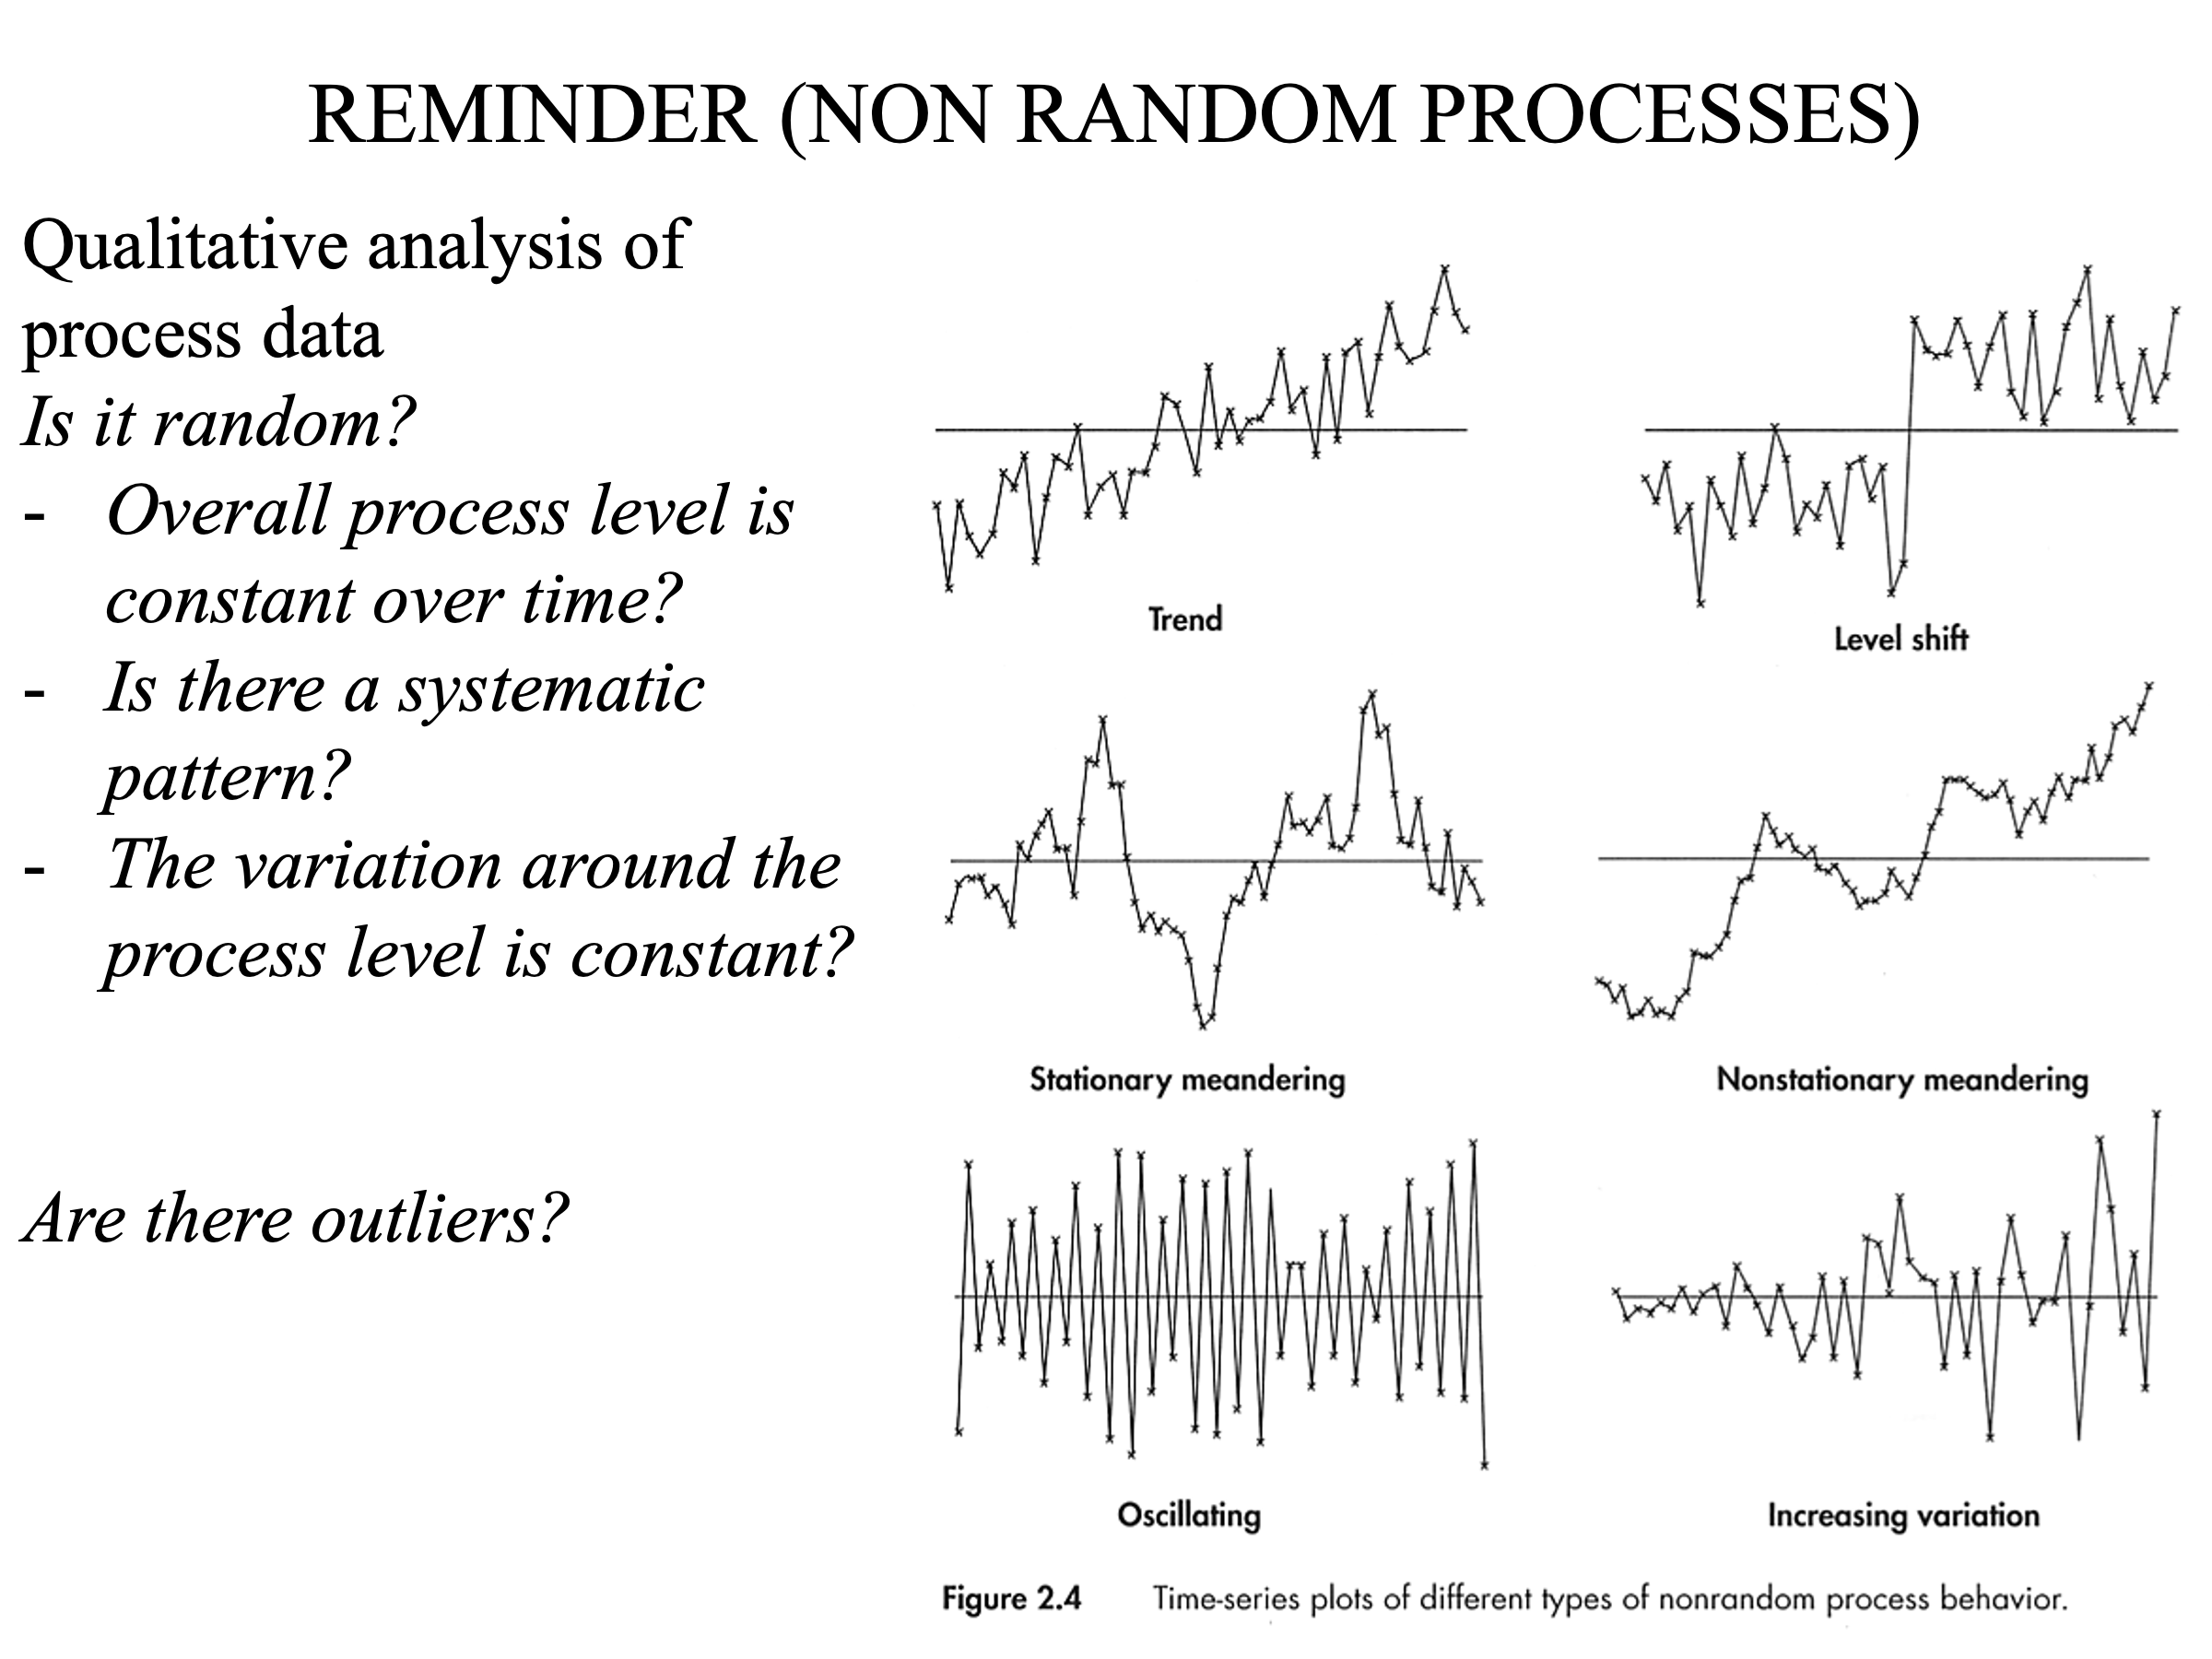

# Exercise 1

In a chemical process it is necessary to keep constant the pH of a compound. Measurements are made every hour. Data acquired over the first 48 hours are reported in `ESE4_ex1.csv`.

Identify and fit a model for the data.

<t1 style="color:red"> In a future class:  
Design a SCC control chart and a FVC control chart  

In [23]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

# Import the dataset
data = pd.read_csv('ESE4_ex1.csv')

# Inspect the dataset
data.head()

,EXE1
0,8.67
1,8.65
2,8.64
3,8.67
4,8.74


> ### Solution
>
> Let's first check if:
> - The data are random.
> - (If random) The data are normally distributed.

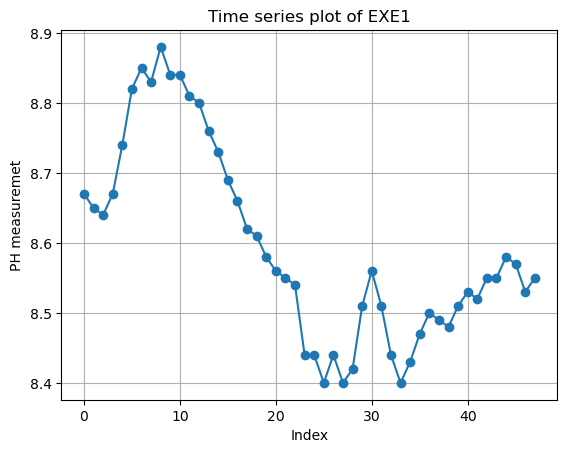

In [24]:
# Plot the data first
plt.plot(data['EXE1'], 'o-')
plt.xlabel('Index')
plt.ylabel('PH measuremet')
plt.title('Time series plot of EXE1')
plt.grid()
plt.show()

In [25]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data['EXE1'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

Runs test p-value = 0.000


> The runs test gives a null p-value, this means that the data are <span style="color:red"> not random </span>. 
>
> Plot also the autocorrelation and partial autocorrelation functions of the data. Use the `plot_acf` and `plot_pacf` functions from the `statsmodels` package.

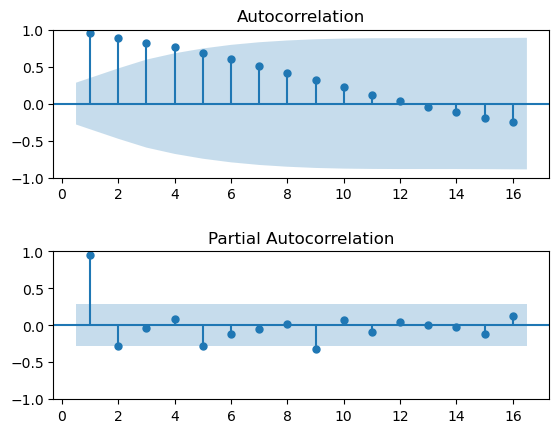

In [26]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['EXE1'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['EXE1'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> There is a strong positive correlation. Decay of autocorrelation coefficients is not exponential.
> Based on ACF analysis, we can state that the process is non-stationary
>
> We can observe with a scatterplot the correlation between $X(t)$ and $X(t-1)$.

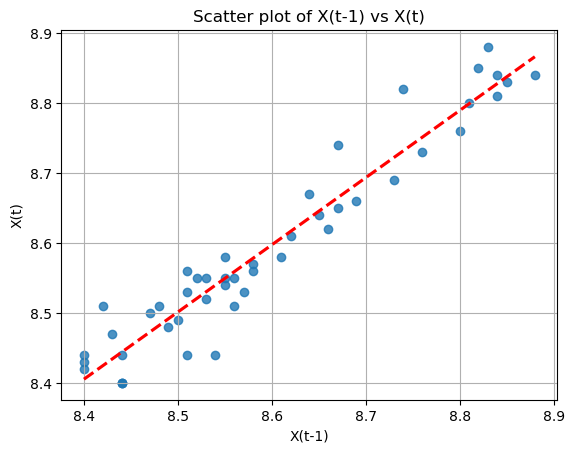

In [27]:
#calculate the lag1 from data
data['lag1'] = data['EXE1'].shift(1)

#create scatterplot with regression line using seaborn and set axis labels
sns.regplot(x=data['lag1'], y=data['EXE1'], ci=None, line_kws={'color':'red', 'ls':'--'})
plt.title('Scatter plot of X(t-1) vs X(t)')
plt.xlabel('X(t-1)')
plt.ylabel('X(t)')
plt.title('Scatter plot of X(t-1) vs X(t)')
plt.grid()



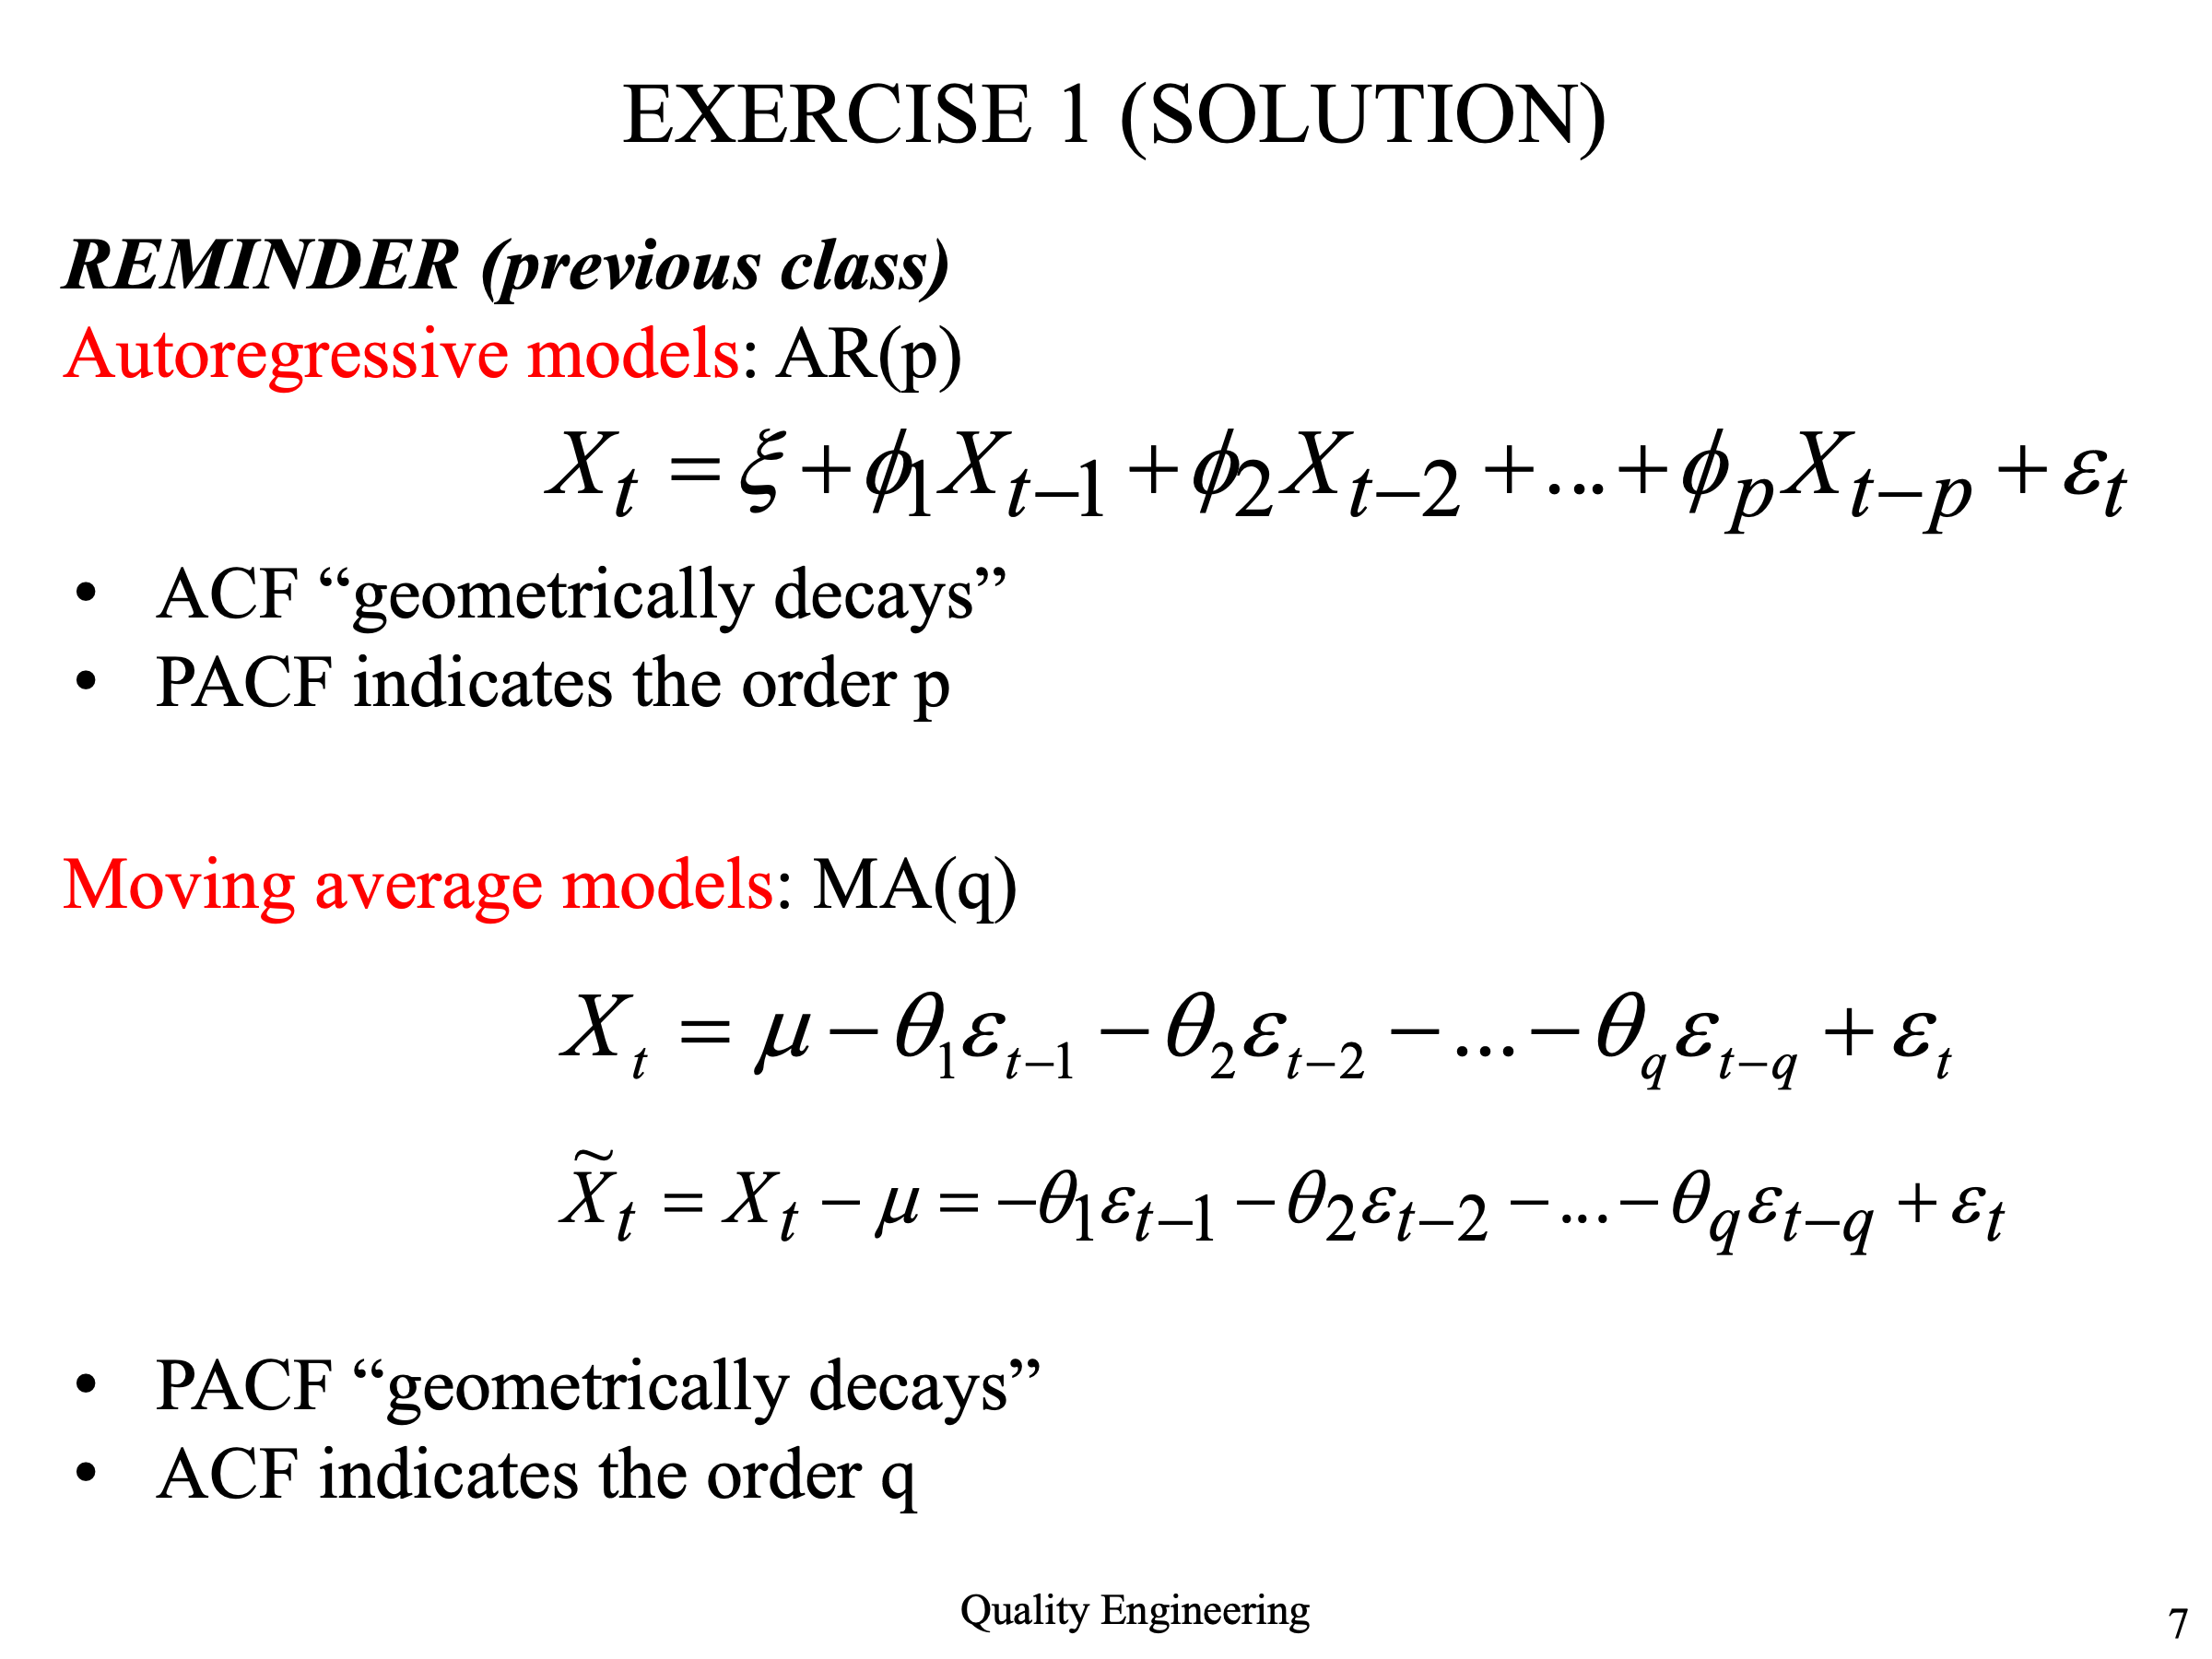
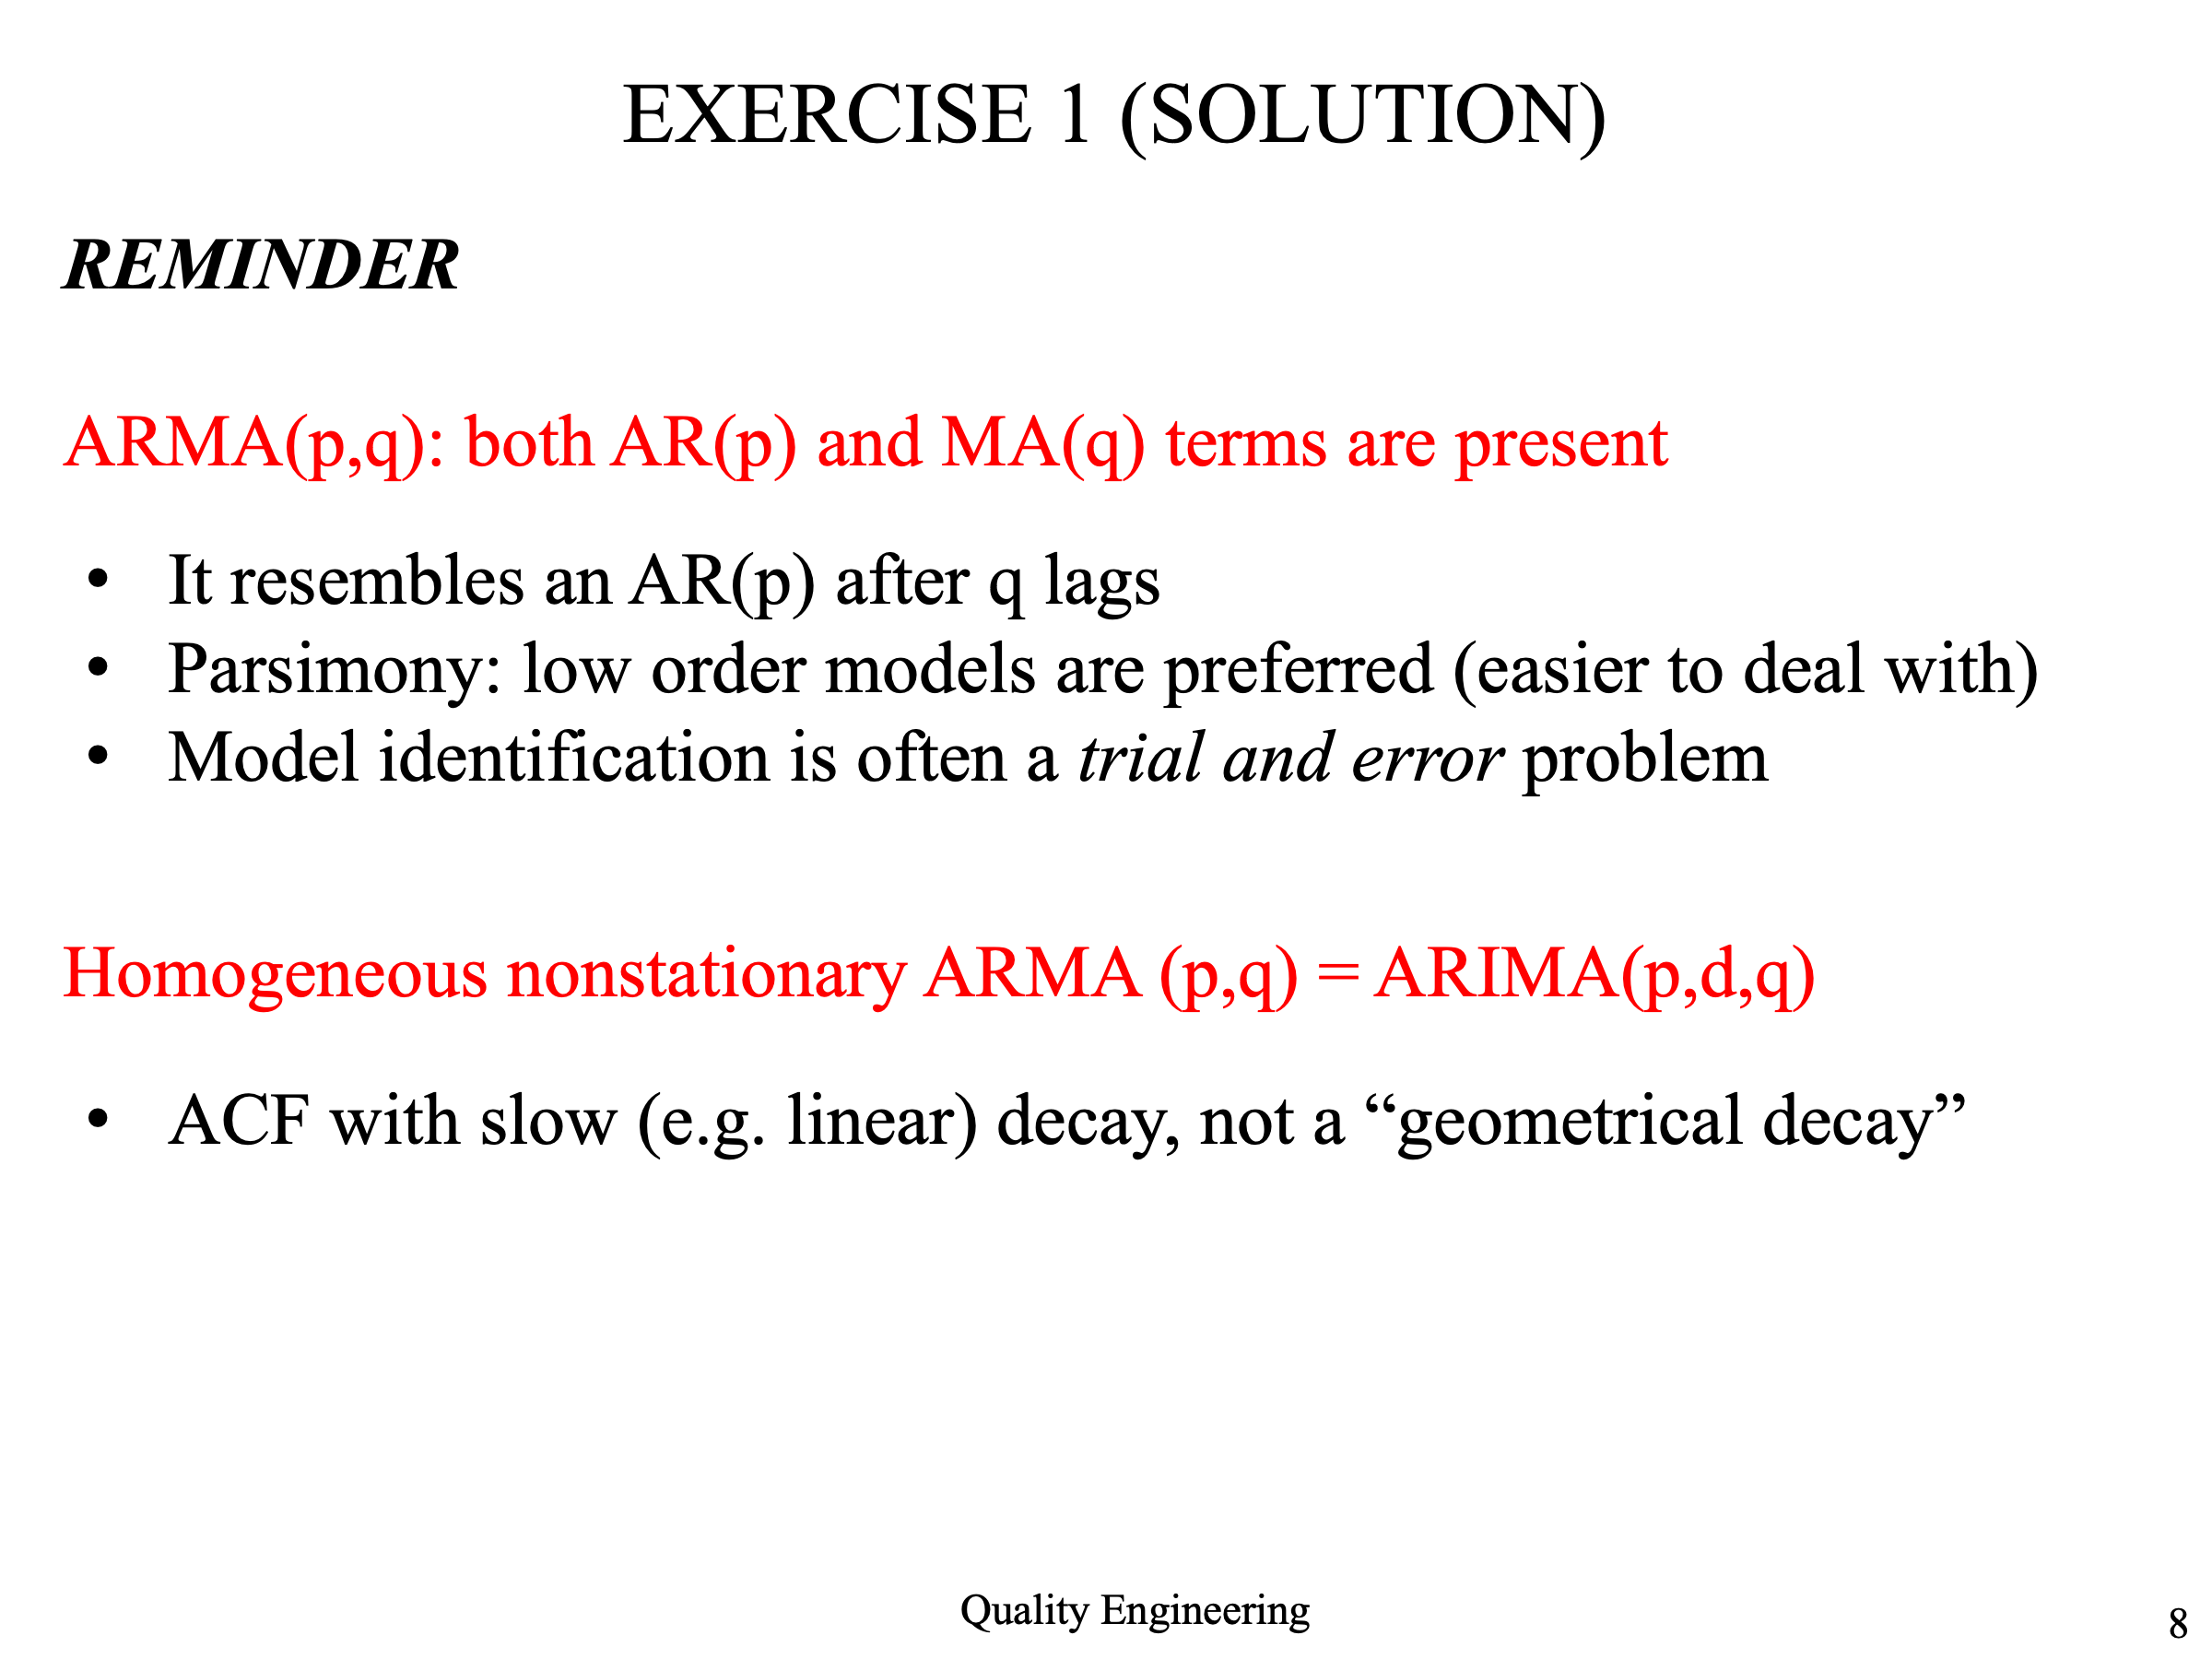
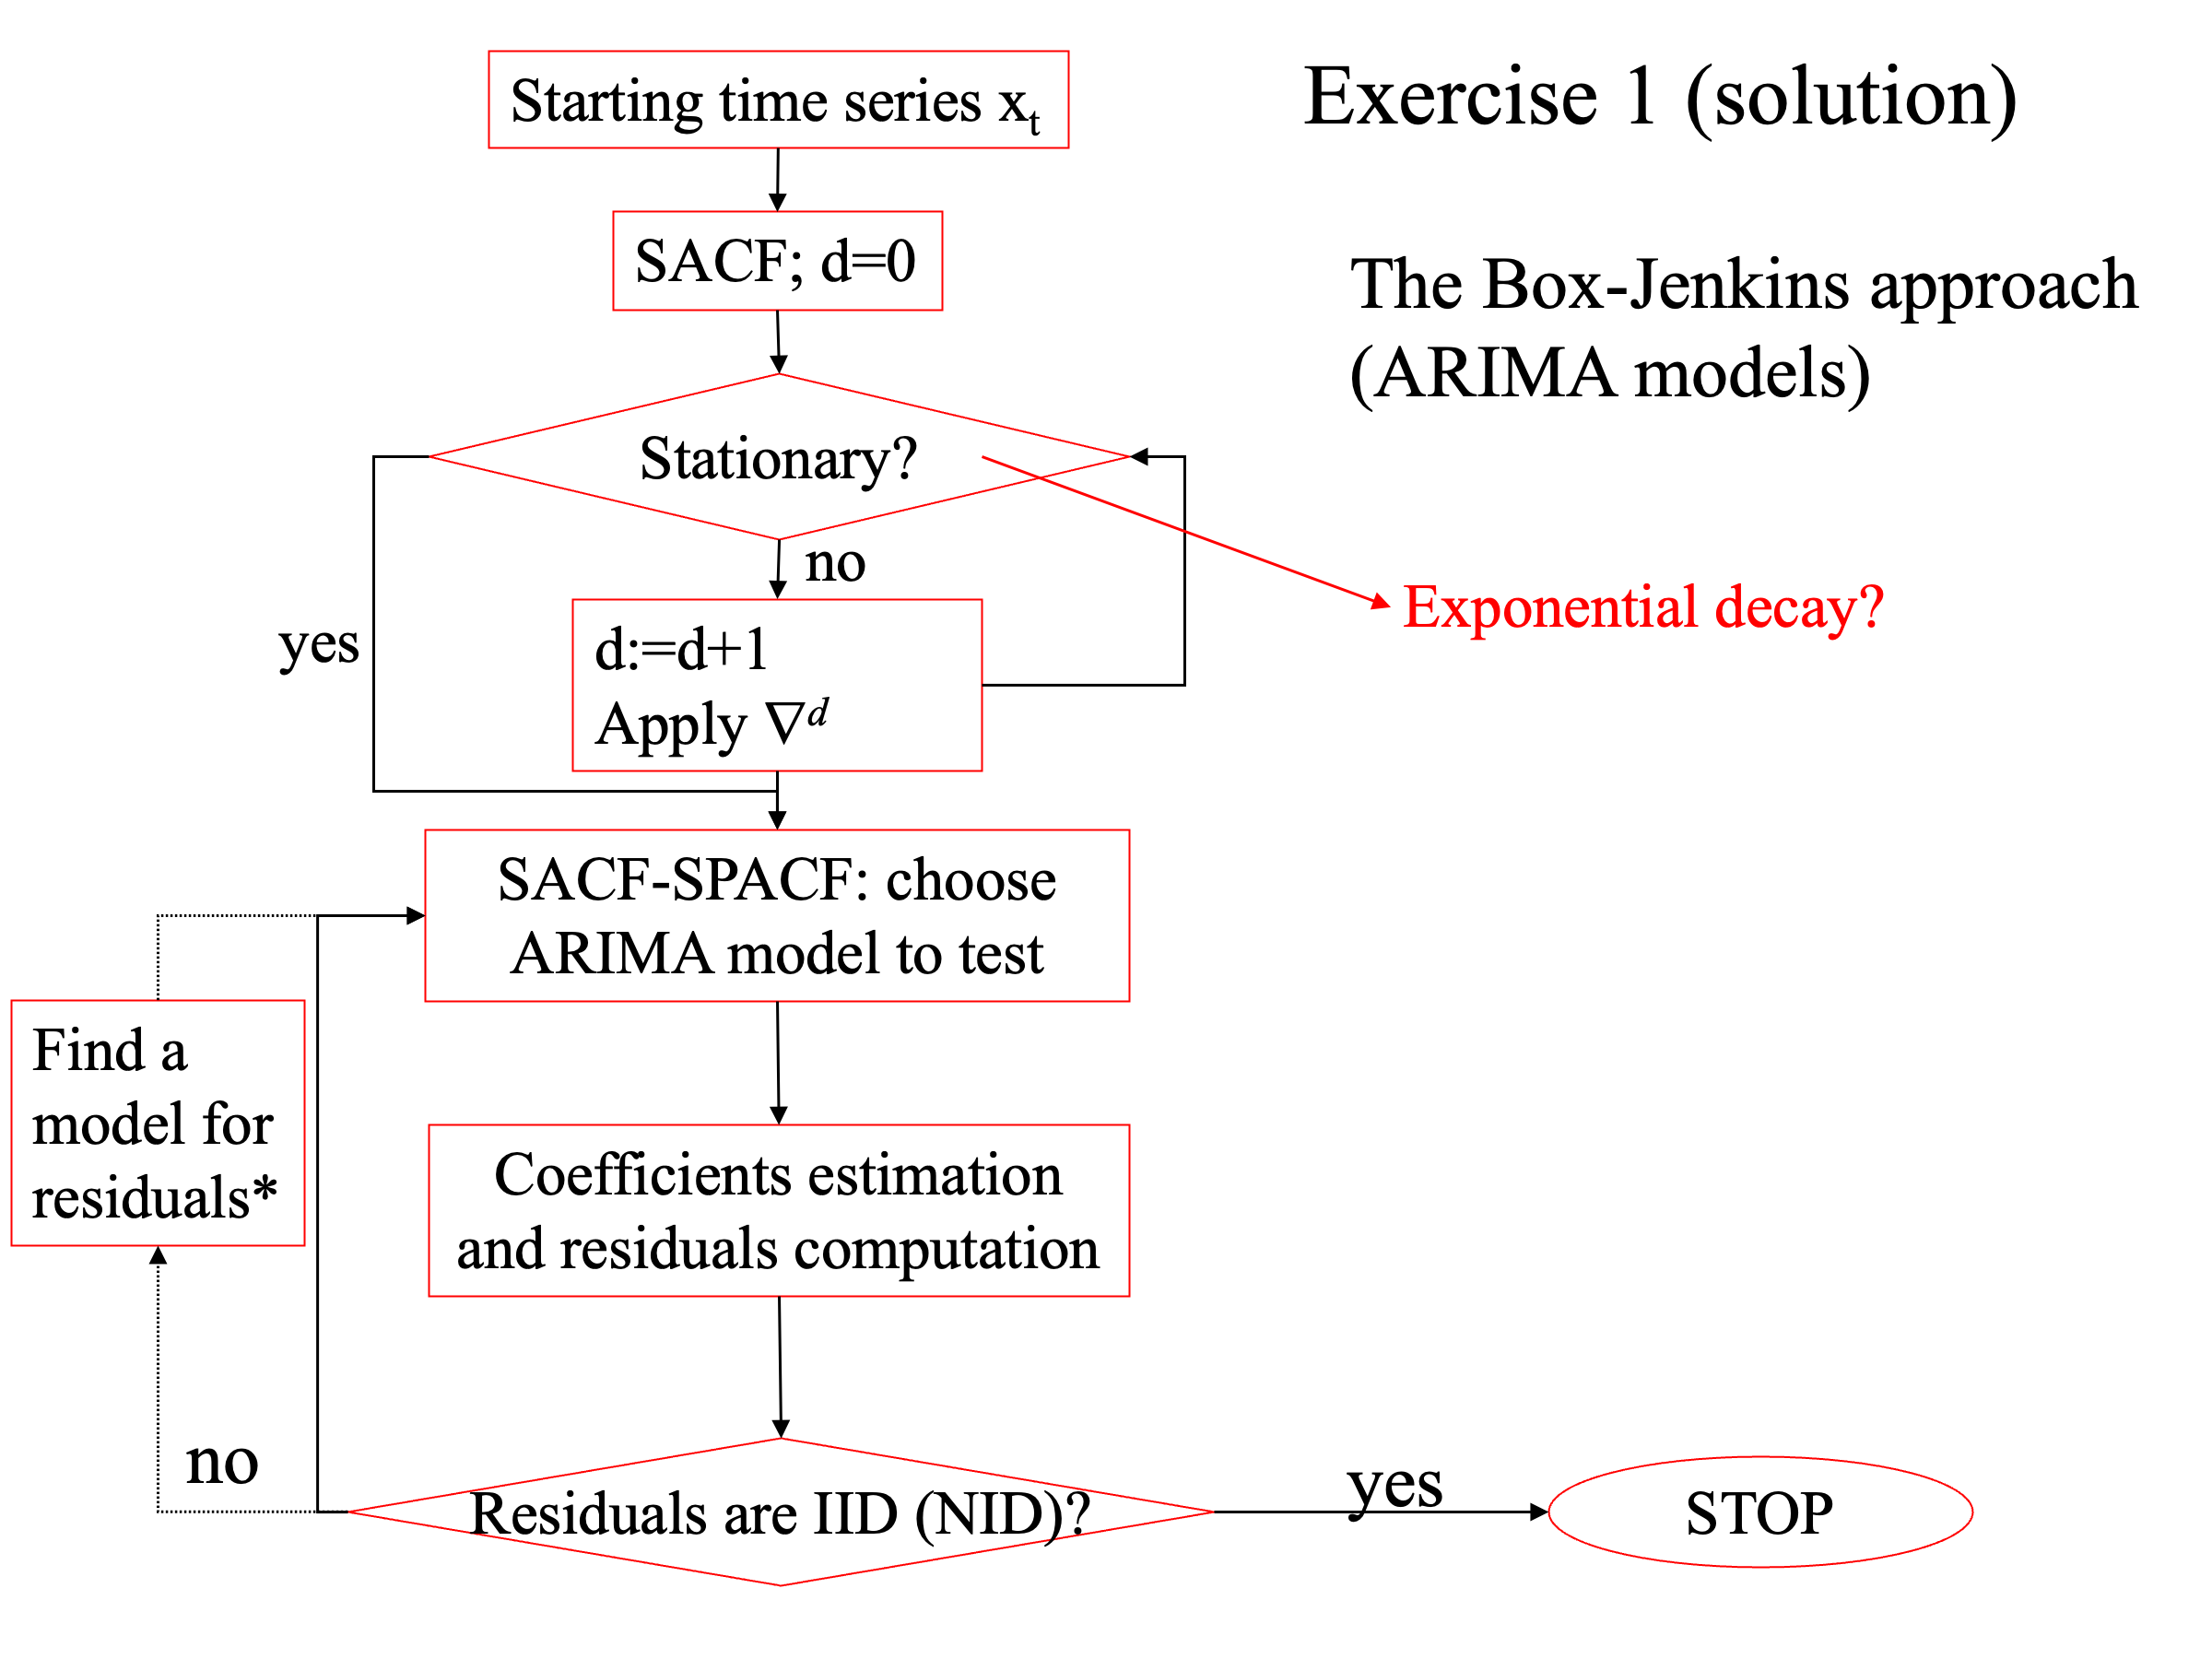

> Let's apply the time difference operator to our time serie data

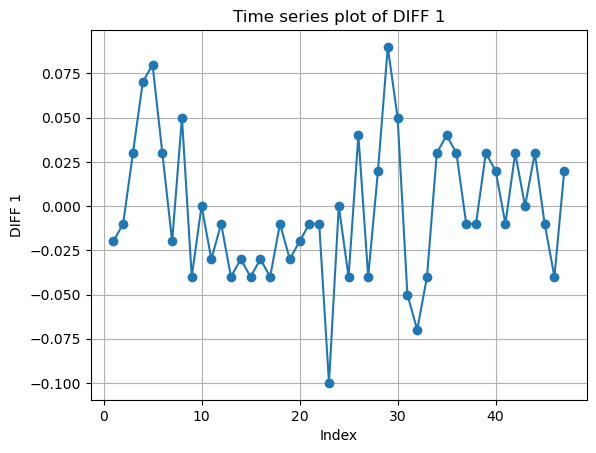

In [28]:
#calculate the difference between the data and the lag1
data['diff1'] = data['EXE1'] - data['lag1']

plt.plot(data['diff1'], 'o-')
plt.xlabel('Index')
plt.ylabel('DIFF 1')
plt.title('Time series plot of DIFF 1')
plt.grid()
plt.show()

> Let's check if differences at lag 1 are NID

In [29]:
#Let's calculate the p-value (exclude the first value because it is null)
_, pval_runs = runstest_1samp(data['diff1'][1:], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

Runs test p-value = 0.230


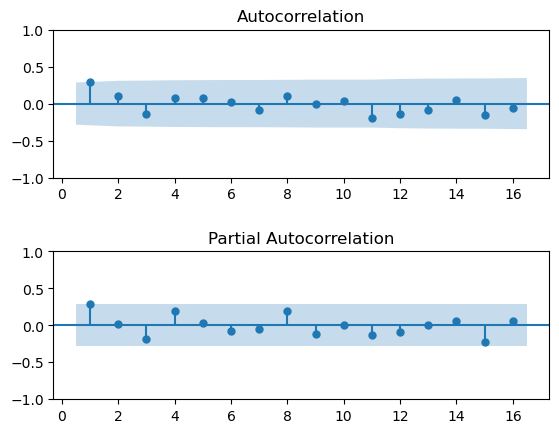

In [30]:
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['diff1'][1:], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['diff1'][1:], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()


In [33]:
from statsmodels.tsa.stattools import acf

n = len(data['diff1'][1:])

#autocorrelation function
[acf_values, lbq, _] = acf(data['diff1'][1:], nlags = int(np.sqrt(n)), qstat=True, fft = False)

#Bartlett's test at lag 1
alpha = 0.05
lag_test = 1
rk = acf_values[lag_test]
z_alpha2 = stats.norm.ppf(1-alpha/2)
print('Test statistic rk = %f' % rk)
print('Rejection region starts at %f' % (z_alpha2/np.sqrt(n)))

Test statistic rk = 0.288387
Rejection region starts at 0.285890


This is a typical borderline situation. At 95% confidence, we should reject the randomness assumption. In this case, we may proceed by fitting an `AR(1)` model on the transformed data by applying the difference operator, and check if residuals are NID. If residuals are NID, the resulting model would be an `ARIMA(1,1,0)`.
Another option is to accept the transformed data are barely random. If we follow this second path, we shall verify if they are also normal. Let's follow this second route (we'll see examples of `ARIMA(1,1,0)` models later on). 

Shapiro-Wilk test p-value = 0.188


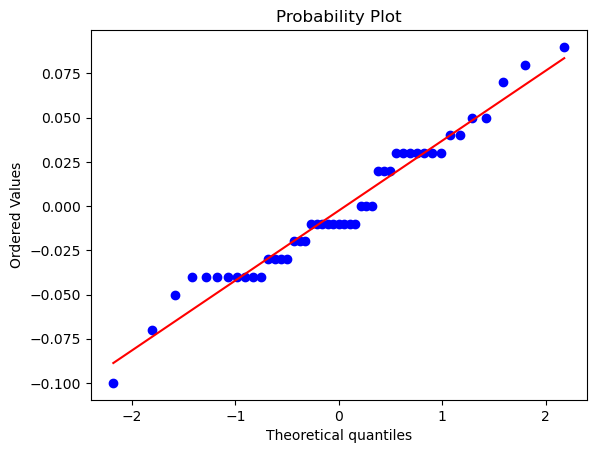

In [34]:
# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(data['diff1'][1:])
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the qqplot
stats.probplot(data['diff1'][1:], dist="norm", plot=plt)
plt.show()

> The process is modeled as a <t1 style="color:red"> RANDOM WALK </t1>
>
> **Random Walk**:
> - $Y_{t} = Y_{t-1} + \epsilon_{t} $

## Point b
It is the best model? Is this the best one?
We can also try an AR(1) model directly on the original data (no application of the difference operator)


In [35]:
#calculate a regression model with constant and lag1
import statsmodels.api as sm
import qda

x = data['lag1'][1:]
x = sm.add_constant(data['lag1'][1:]) # this command is used to consider a constant to the model, is equivalent to create and add a column of ones
y = data['EXE1'][1:]
model = sm.OLS(y, x).fit()

qda.summary(model)


REGRESSION EQUATION
-------------------
EXE1 =  + 0.344 const + 0.960 lag1

COEFFICIENTS
------------
 Term   Coef  SE Coef  T-Value    P-Value
const 0.3439   0.3510   0.9799 3.3238e-01
 lag1 0.9597   0.0408  23.5067 6.5730e-27

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.0392 0.9247      0.923

ANALYSIS OF VARIANCE
---------------------
    Source   DF  Adj SS  Adj MS  F-Value    P-Value
Regression  1.0  0.8497  0.8497 552.5667 6.5730e-27
     const  1.0  0.0015  0.0015   0.9602 3.3238e-01
      lag1  1.0  0.8497  0.8497 552.5667 6.5730e-27
     Error 45.0  0.0692  0.0015      NaN        NaN
     Total 46.0  0.9189     NaN      NaN        NaN


> Note that the p-value of the constant term is 0.332. 
>
><t1 style="color:red"> Let's re-calculate the model removing the constant term </t1>

In [36]:
x = data['lag1'][1:]
y = data['EXE1'][1:]
model = sm.OLS(y, x).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
EXE1 =  + 1.000 lag1

COEFFICIENTS
------------
Term   Coef  SE Coef  T-Value     P-Value
lag1 0.9997   0.0007 1503.228 1.4733e-109

MODEL SUMMARY
-------------
     S  R-sq  R-sq(adj)
0.0392   1.0        1.0

ANALYSIS OF VARIANCE
---------------------
    Source   DF    Adj SS    Adj MS    F-Value     P-Value
Regression  1.0 3471.6382 3471.6382 2.2597e+06 1.4733e-109
      lag1  1.0 3471.6382 3471.6382 2.2597e+06 1.4733e-109
     Error 46.0    0.0707    0.0015        NaN         NaN
     Total 47.0 3471.7089       NaN        NaN         NaN


> <t1 style="color:red"> We have found again the random walk model! </t1>
>
> $$EXE1 = 0.9997 \cdot lag1$$
>
> Let's check assumptions on residuals:
> - Normality
> - Time independence

Shapiro-Wilk test p-value on the residuals = 0.192


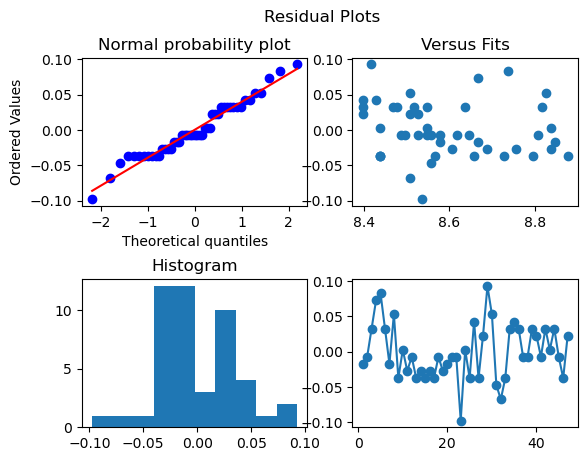

In [37]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(model.resid)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

Runs test p-value on the residuals = 0.230


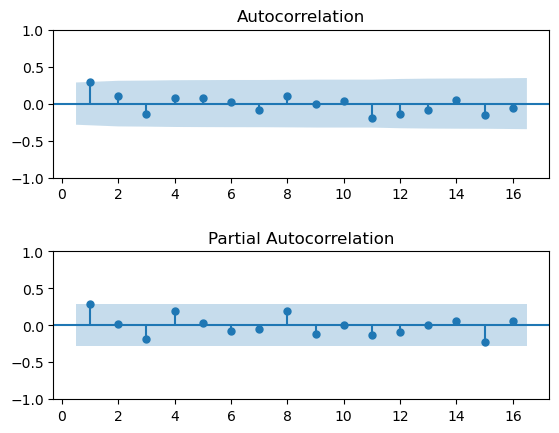

In [38]:
_, pval_runs_res = runstest_1samp(model.resid, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

Let's check autocorrelation at lag 1 with Bartlett.
At 5% significance level:

In [39]:
from statsmodels.tsa.stattools import acf

#autocorrelation function
[acf_value, lbq, _] = acf(model.resid, nlags = int(len(model.resid)/3) , qstat=True)

#Bartlett's test at lag 1
lag_test=1
rk=abs(acf_value[lag_test])
alpha = 0.05 # significance level
z_alpha2 = stats.norm.ppf(1-alpha/2)
print('Test statistic rk = %f' % rk)
print('Rejection region starts at %f' % (z_alpha2/np.sqrt(len(model.resid))))


Test statistic rk = 0.288386
Rejection region starts at 0.285890


Same result as before (indeed the model is the same, i.e., random walk)
The Bartlett's null hypothesis is barely rejected at 95% confidence but not rejected at 99% confidence.  

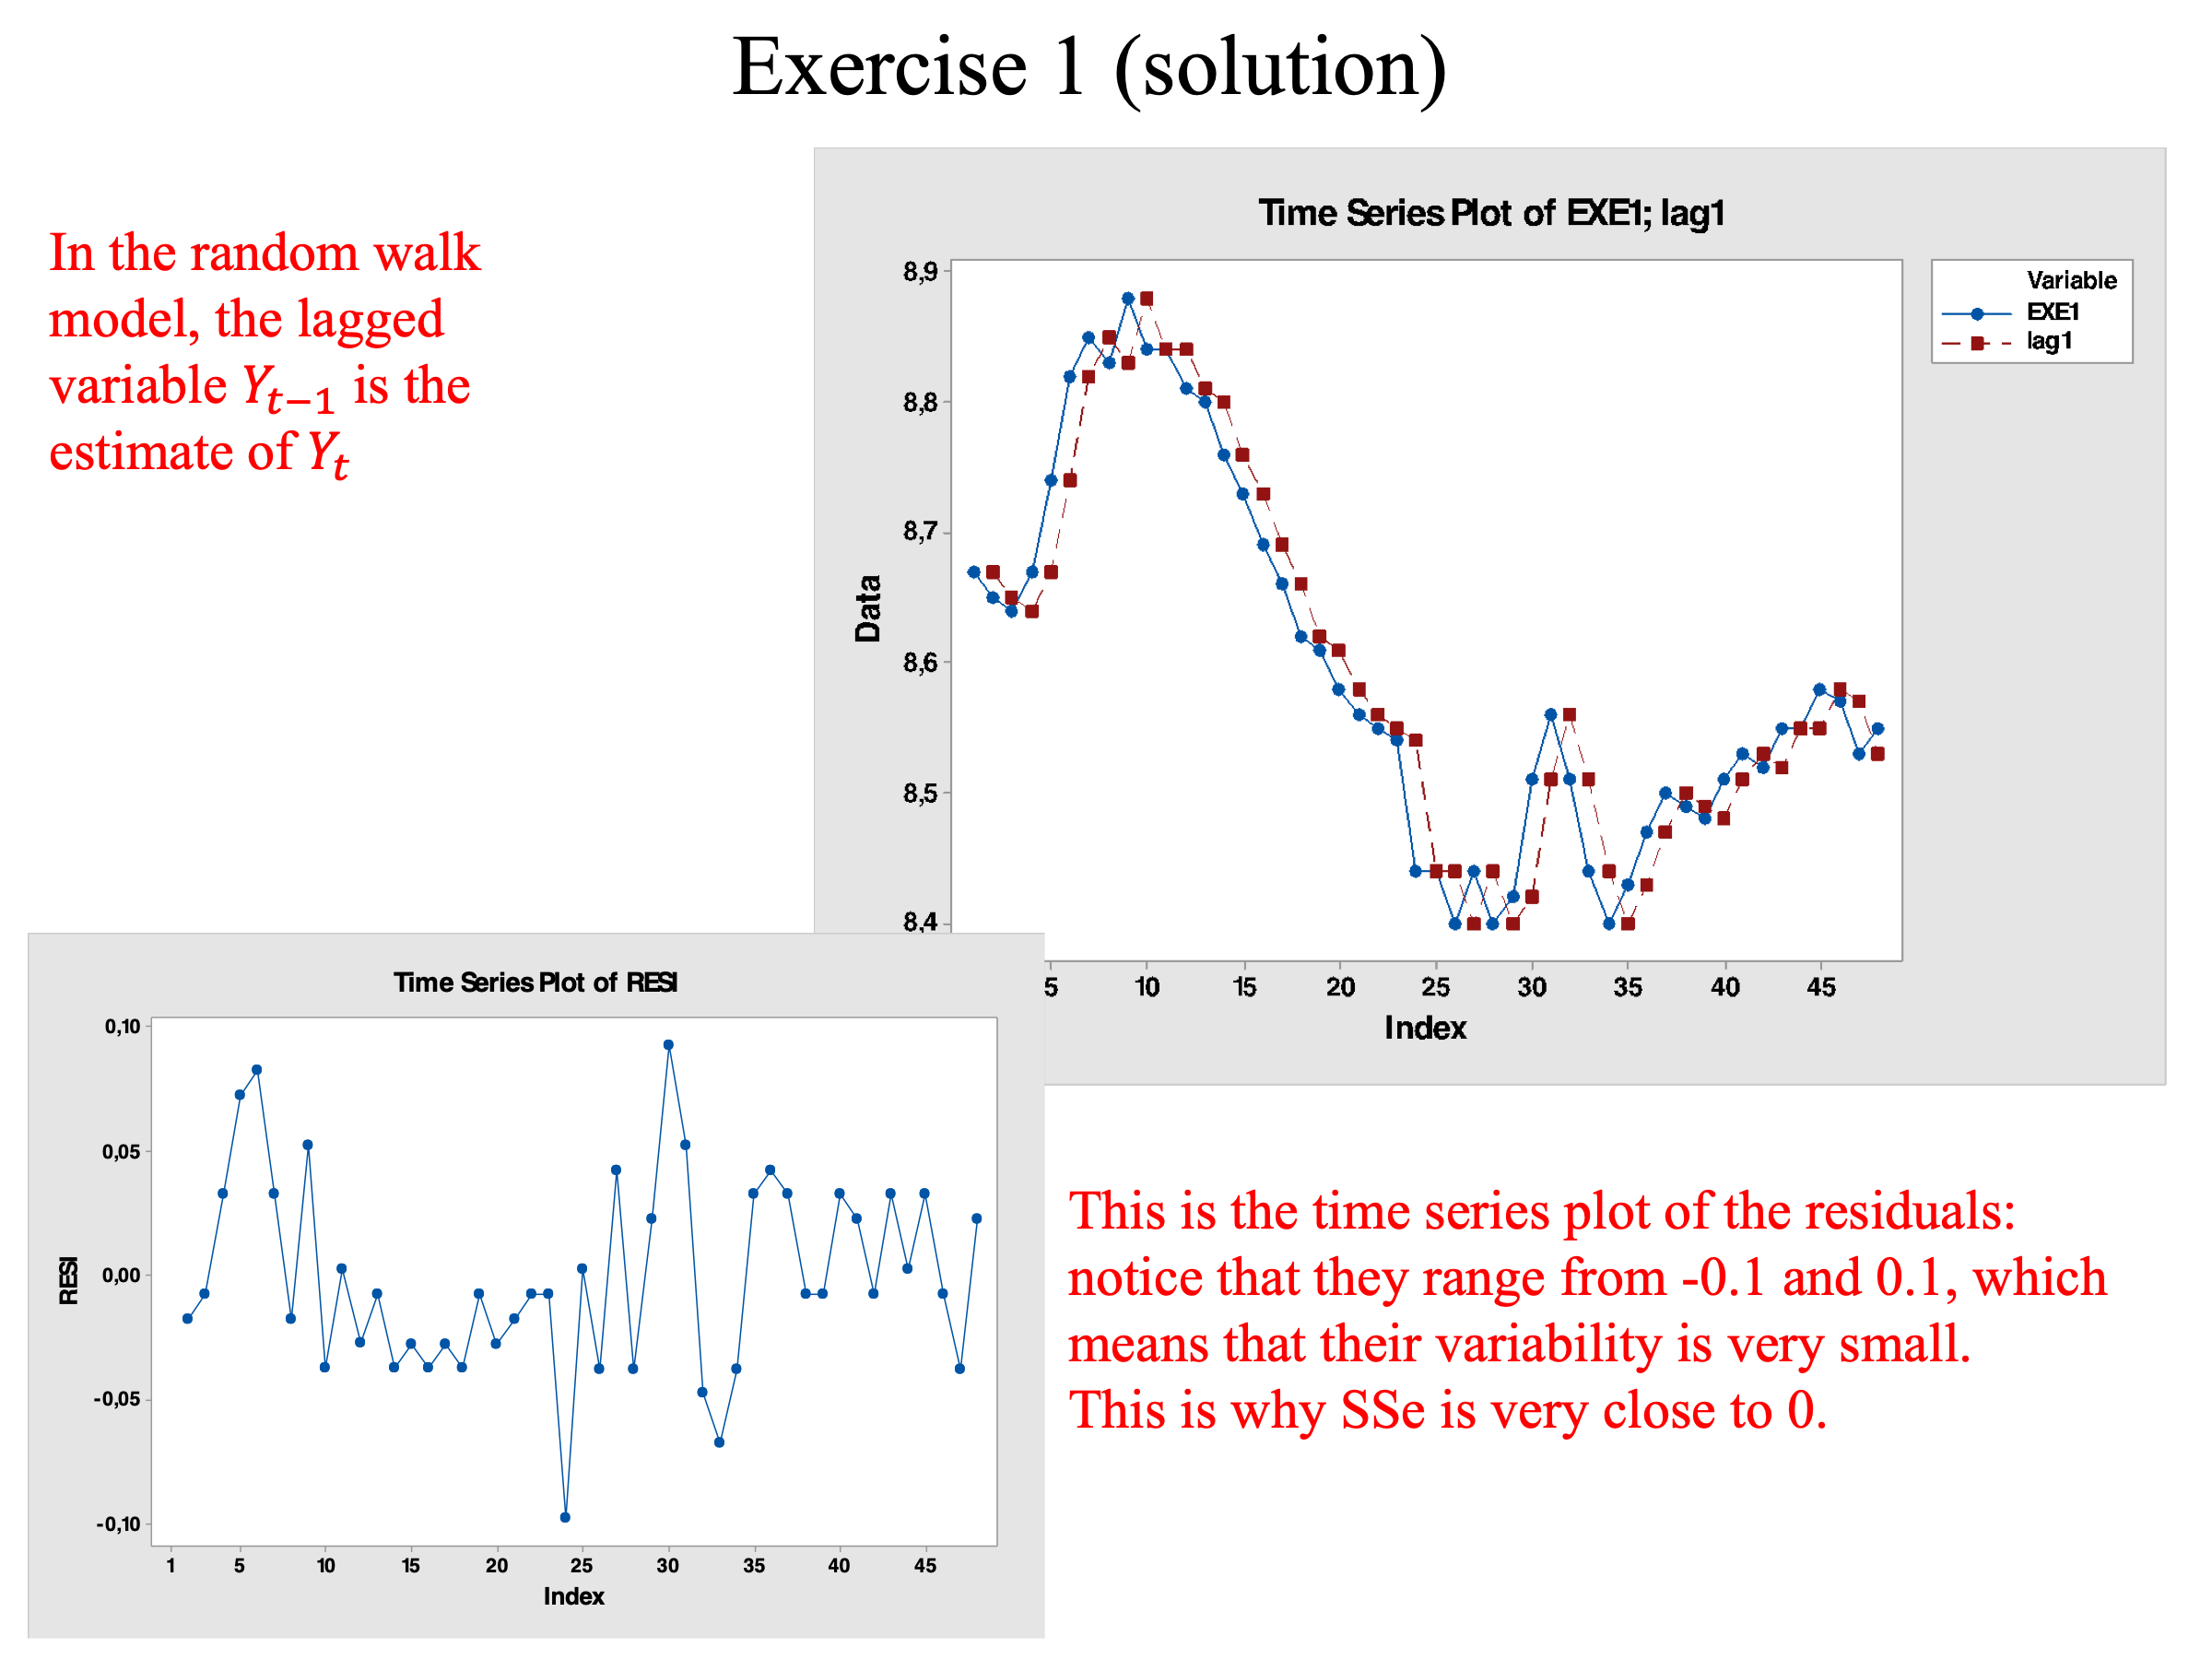

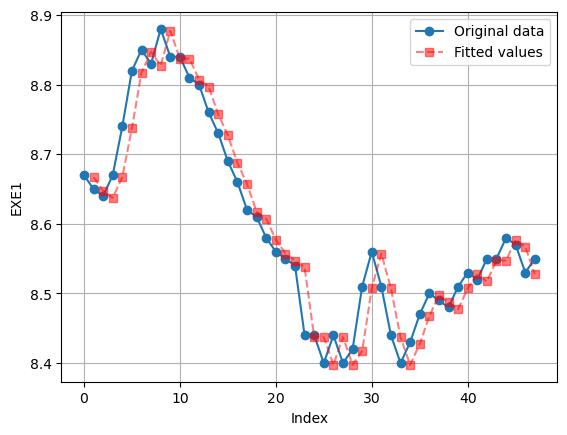

In [40]:
plt.plot(data['EXE1'], 'o-', label='Original data')
plt.xlabel('Index') 
plt.ylabel('EXE1')
plt.plot(model.fittedvalues, 's--', color='red', label='Fitted values', alpha=0.5)
plt.legend()
plt.grid()
plt.show()

## Try at home
Try to fit an ARIMA(1,1,0) on this time series and verify if the model is appropriate or not

In [ ]:
data['diff1_lag1'] = data['diff1'].shift(1)

In [ ]:
x = data['diff1_lag1'][2:]
x = sm.add_constant(x) # this command is used to consider a constant to the model, is equivalent to create and add a column of ones
y = data['diff1'][2:]
model = sm.OLS(y, x).fit()

qda.summary(model)

In [ ]:
x = data['diff1_lag1'][2:]
y = data['diff1'][2:]
model = sm.OLS(y, x).fit()

qda.summary(model)

In [ ]:
_, pval_runs_res = runstest_1samp(model.resid, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

In [ ]:
# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the qqplot
stats.probplot(model.resid, dist="norm", plot=plt)
plt.show()